# Illustrating event width

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import hmp
from itertools import cycle
from scipy import stats
import bambi as bmb 
import pandas as pd
import arviz as az
from itertools import product
from os import listdir
import scipy.optimize as opt
from hmp import simulations


colors = ['royalblue','darkgreen','indianred','goldenrod', 'pink', 'black']

def fit_or_load(filename, path, model):
    if filename not in listdir(path):
        fit = model.fit(inference_method='nuts_numpyro',idata_kwargs={"log_likelihood": True})
        fit.to_netcdf(path+'/'+filename)
    else:
        fit = az.from_netcdf(path+'/'+filename)
    return fit

## plot for the different target pattern width

Simulating ./event_duration_example_raw.fif
./event_duration_example_raw.fif simulated
Processing participant ./event_duration_example_raw.fif's continuous eeg
2 trials were retained for participant ./event_duration_example_raw.fif


/home/gweindel/miniconda3/envs/bays_hmp/lib/python3.11/site-packages/mne/epochs.py:2986: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  metadata.iloc[:, 0] = ""


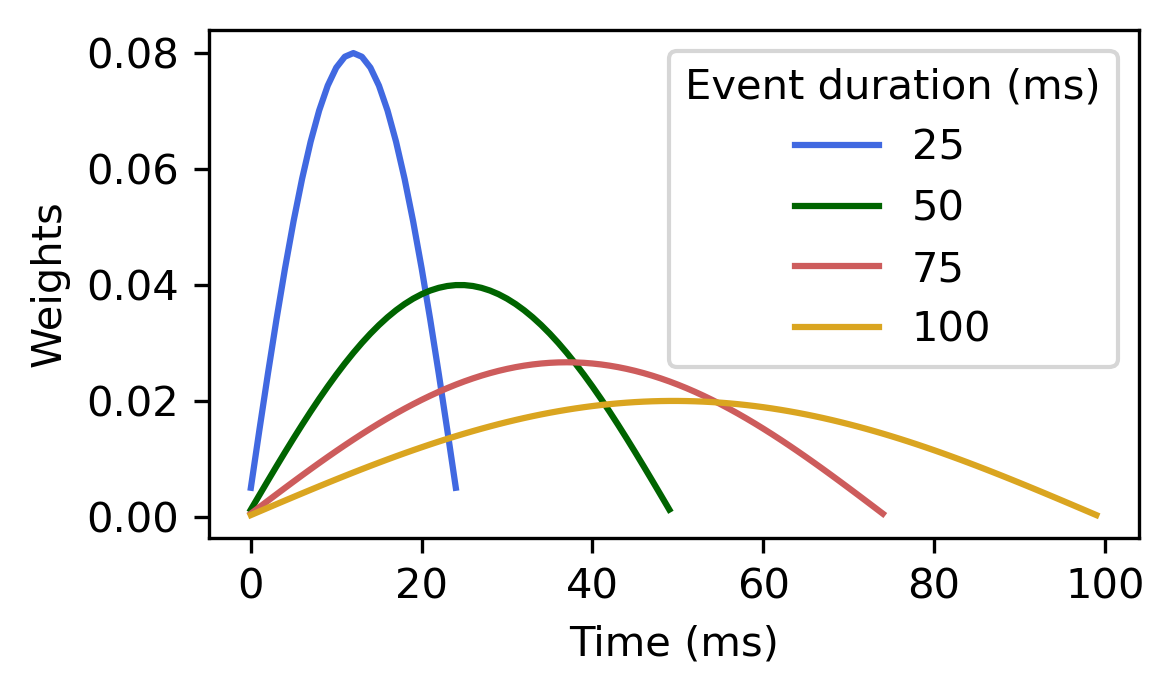

In [2]:
from scipy.stats import gamma
cpus = 2 # For multiprocessing, usually a good idea to use multiple CPUs as long as you have enough RAM

n_trials = 2 #Number of trials to simulate
sfreq = 1000
##### Here we define the sources of the brain activity (event) for each trial
Nevents = 1
frequency = 10. #Frequency of the event defining its duration, half-sine of 10Hz = 50ms
amplitude = 1e-8 #Amplitude of the event in nAm, defining signal to noise ratio
shape = 2 #shape of the gamma distribution
means = np.array([200])/shape #Mean duration of the stages in ms
names = simulations.available_sources()[0] #Which source to activate at each stage (see atlas when calling simulations.available_sources())

sources = []
for source in zip(names, means): #One source = one frequency, one amplitude and a given by-trial variability distribution
    sources.append([source[0], frequency, amplitude, gamma(shape, scale=source[1])])

# Function used to generate the data
file = simulations.simulate(sources, n_trials, cpus, 'event_duration_example', overwrite=True, sfreq=sfreq)

#Recovering the events to epoch the data (in the number of trials defined above)
events = np.load(file[1])
resp_trigger = int(np.max(np.unique(events[:,2])))#Resp trigger is the last source in each trial
event_id = {'stimulus':1}#trigger 1 = stimulus
resp_id = {'response':resp_trigger}
#Keeping only stimulus and response triggers

eeg_data = hmp.utils.read_mne_data(file[0], event_id=event_id, resp_id=resp_id, sfreq=sfreq, 
            events_provided=events, verbose=False)

hmp_dat = hmp.utils.transform_data(eeg_data, apply_standard=False, n_comp=4)
init = hmp.models.hmp(hmp_dat, sfreq=eeg_data.sfreq, event_width=50, cpus=cpus)#Initialization of the model

plt.figure(figsize=(4,2.2), dpi=300)

durations = [25,50,75,100]
for i, duration in enumerate(durations):
    init = hmp.models.hmp(hmp_dat, sfreq=eeg_data.sfreq, event_width=duration, cpus=cpus)#Initialization of the model
    plt.plot(init.template, label=duration, color=colors[i])
plt.legend(title='Event duration (ms)')
plt.xlabel('Time (ms)')
plt.ylabel('Weights')
plt.savefig('../../plots/event_duration-illustration.png',dpi=300,transparent=True,bbox_inches='tight')

# plt.savefig('Event_duration-illustration.png', dpi=300)

## Simulating 25ms events as the ground truth

/home/gweindel/owncloud/projects/RUGUU/main_hmp/hmp/simulations.py:191: UserWarning: simulated/demo_25-dur_raw.fif exists no new simulation performed
  warn(f'{subj_file} exists no new simulation performed', UserWarning)
/home/gweindel/miniconda3/envs/bays_hmp/lib/python3.11/site-packages/mne/epochs.py:2986: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  metadata.iloc[:, 0] = ""


Processing participant simulated/demo_25-dur_raw.fif's continuous eeg
100 trials were retained for participant simulated/demo_25-dur_raw.fif
100


  0%|          | 0/770 [00:00<?, ?it/s]

75


  0%|          | 0/770 [00:00<?, ?it/s]

50


  0%|          | 0/770 [00:00<?, ?it/s]

25


  0%|          | 0/770 [00:00<?, ?it/s]

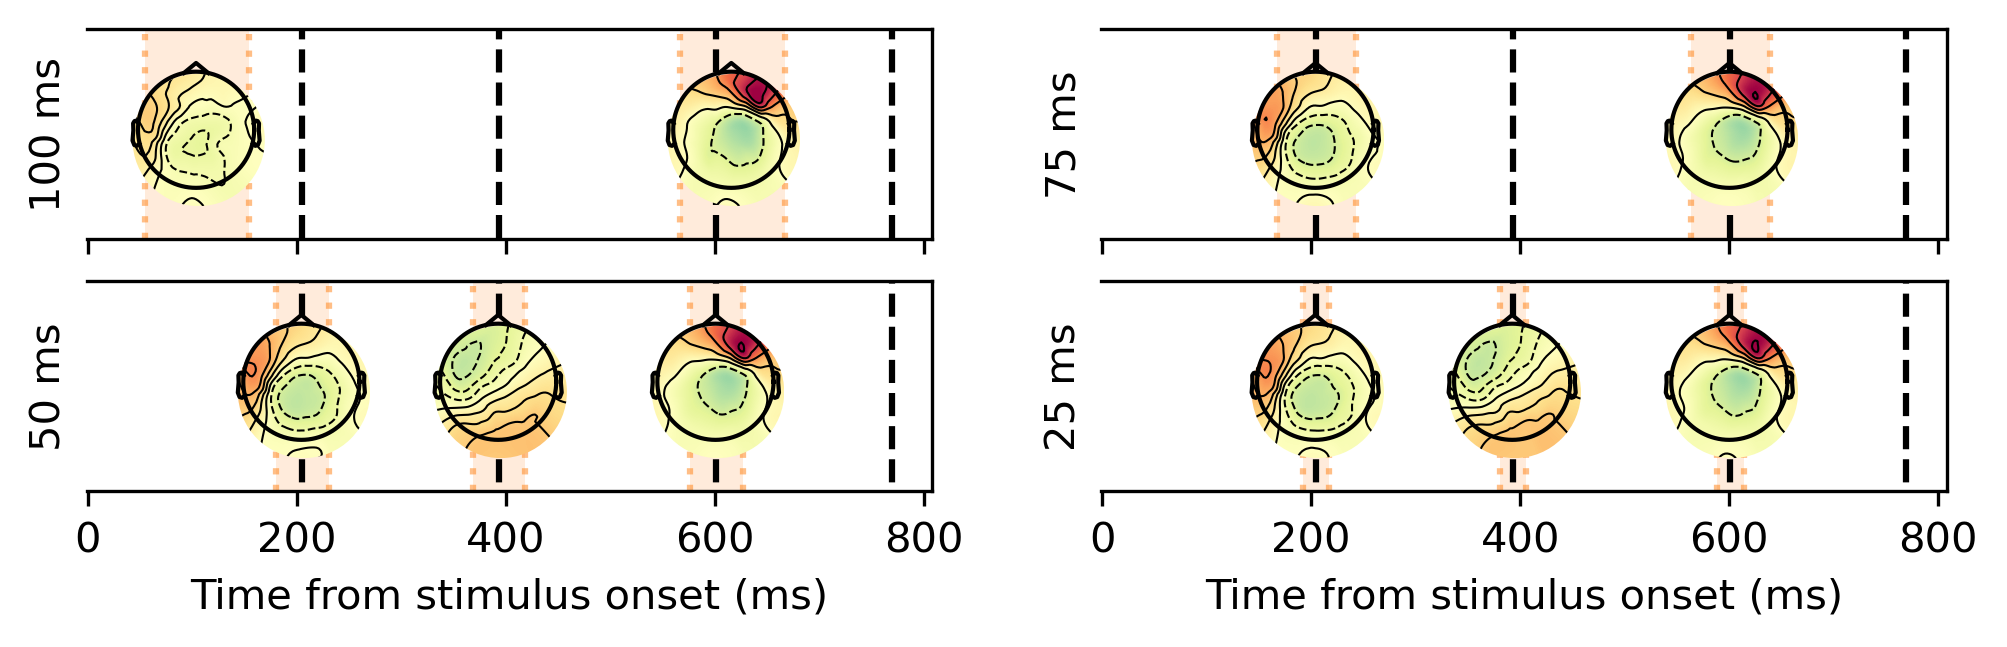

In [8]:
## Imports and code specific to the simulation (see tutorial 3 and 4 for real data)
import os
import mne
from hmp import simulations
from scipy.stats import gamma as sp_dist
from hmp.utils import gamma_scale_to_mean,gamma_mean_to_scale

scale_to_mean, mean_to_scale = gamma_scale_to_mean,gamma_mean_to_scale

seed = 0
rng = np.random.default_rng(seed=seed)#Setting seeed for reproducibility
true_dur = 25
true_freq = 1000/true_dur/2# conversion to frequency given half-sine duration above
version = '44b3500'
cpus = 1 # For multiprocessing, usually a good idea to use multiple CPUs as long as you have enough RAM
path = os.path.join('simulated/')#Where simulated data will go, create that folder if you don't have it where you're executing the code

#EEG specific infos from MNE's sample participant
info = simulations.simulation_info()
all_other_chans = range(len(info.ch_names[:-61]))#non-eeg
chan_list = list(np.arange(len(info.ch_names)))
chan_list = [e for e in chan_list if e not in all_other_chans]
chan_list.pop(52)#Bad elec
info = mne.pick_info(info, sel=chan_list)

#Fixed simulation parameters
amplitude = 1e-6

# Pick 4 sources (last is the response event) from the sample participant source space
Nevents = 3
all_sources = simulations.available_sources()
name_sources = all_sources[rng.choice(np.arange(len(all_sources)),Nevents+1, replace=False)]
n_trials = 100#Number of trials to simulate
sfreq = 1000
n_comp = 5
distribution = 'gamma'
shape = 2

#Variable simulation parameters
durations = [25, 50, 75, 100][::-1]
all_combinations = list(durations)

means_list = np.repeat(200,Nevents+1) 
# Function used to generate the data
times = mean_to_scale(means_list, shape)
sources = []
for source in range(len(name_sources)):
    sources.append([name_sources[source], true_freq, amplitude, \
            sp_dist(shape, scale=times[source])])
file = simulations.simulate(sources, n_trials, cpus, 'demo_25-dur', path=path, 
                    overwrite=False, sfreq=sfreq, seed=seed)
#Recover info from simulation
generating_events = np.load(file[1])
resp_trigger = int(np.max(np.unique(generating_events[:,2])))#Resp trigger is the last source in each trial
event_id = {'stimulus':1}#trigger 1 = stimulus
resp_id = {'response':resp_trigger}#Response is defined as the last trigger in a sequence of events
#Keeping only stimulus and response triggers
events = generating_events[(generating_events[:,2] == 1) | (generating_events[:,2] == resp_trigger)]#only retain stimulus and response triggers

number_of_sources = len(np.unique(generating_events[:,2])[1:])#one trigger = one source
epoch_data = hmp.utils.read_mne_data(file[0], event_id=event_id, resp_id=resp_id, 
                sfreq=sfreq, events_provided=events, verbose=False)
    
hmp_data = hmp.utils.transform_data(epoch_data, apply_standard=False, n_comp=n_comp)
fig, ax = plt.subplots(2,2, figsize=(8,2),sharex=True, dpi=300)
ax = ax.flatten()
for i,test_event_width in enumerate(durations):
    print(test_event_width)
    # Estimating an HMP model
    test_init = hmp.models.hmp(hmp_data, sfreq=sfreq, event_width=test_event_width, cpus=cpus, distribution=distribution, shape=shape)#Initialization of the model
    random_source_times, _, _, _ = hmp.simulations.simulated_times_and_parameters(generating_events, init=test_init)

    fit = test_init.fit(verbose=False, pval=.05)
    hmp.visu.plot_topo_timecourse(epoch_data, fit, info, test_init, magnify=2, ax=ax[i], sensors=False, 
        times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0), colorbar=False, cmap='Spectral_r')
    ax[i].set_ylabel('%i ms'%test_event_width)
ax[2].set_xlabel('Time from stimulus onset (ms)')
ax[i].set_xlabel('Time from stimulus onset (ms)')
plt.savefig('../../plots/event_duration-25.png',dpi=300,transparent=True,bbox_inches='tight')
plt.show()

## Simulating 100ms events as the ground truth

/home/gweindel/owncloud/projects/RUGUU/main_hmp/hmp/simulations.py:191: UserWarning: simulated/demo_100-dur_raw.fif exists no new simulation performed
  warn(f'{subj_file} exists no new simulation performed', UserWarning)
/home/gweindel/miniconda3/envs/bays_hmp/lib/python3.11/site-packages/mne/epochs.py:2986: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  metadata.iloc[:, 0] = ""


Processing participant simulated/demo_100-dur_raw.fif's continuous eeg
100 trials were retained for participant simulated/demo_100-dur_raw.fif
100


  0%|          | 0/770 [00:00<?, ?it/s]

75


  0%|          | 0/770 [00:00<?, ?it/s]

50


  0%|          | 0/770 [00:00<?, ?it/s]

25


  0%|          | 0/770 [00:00<?, ?it/s]

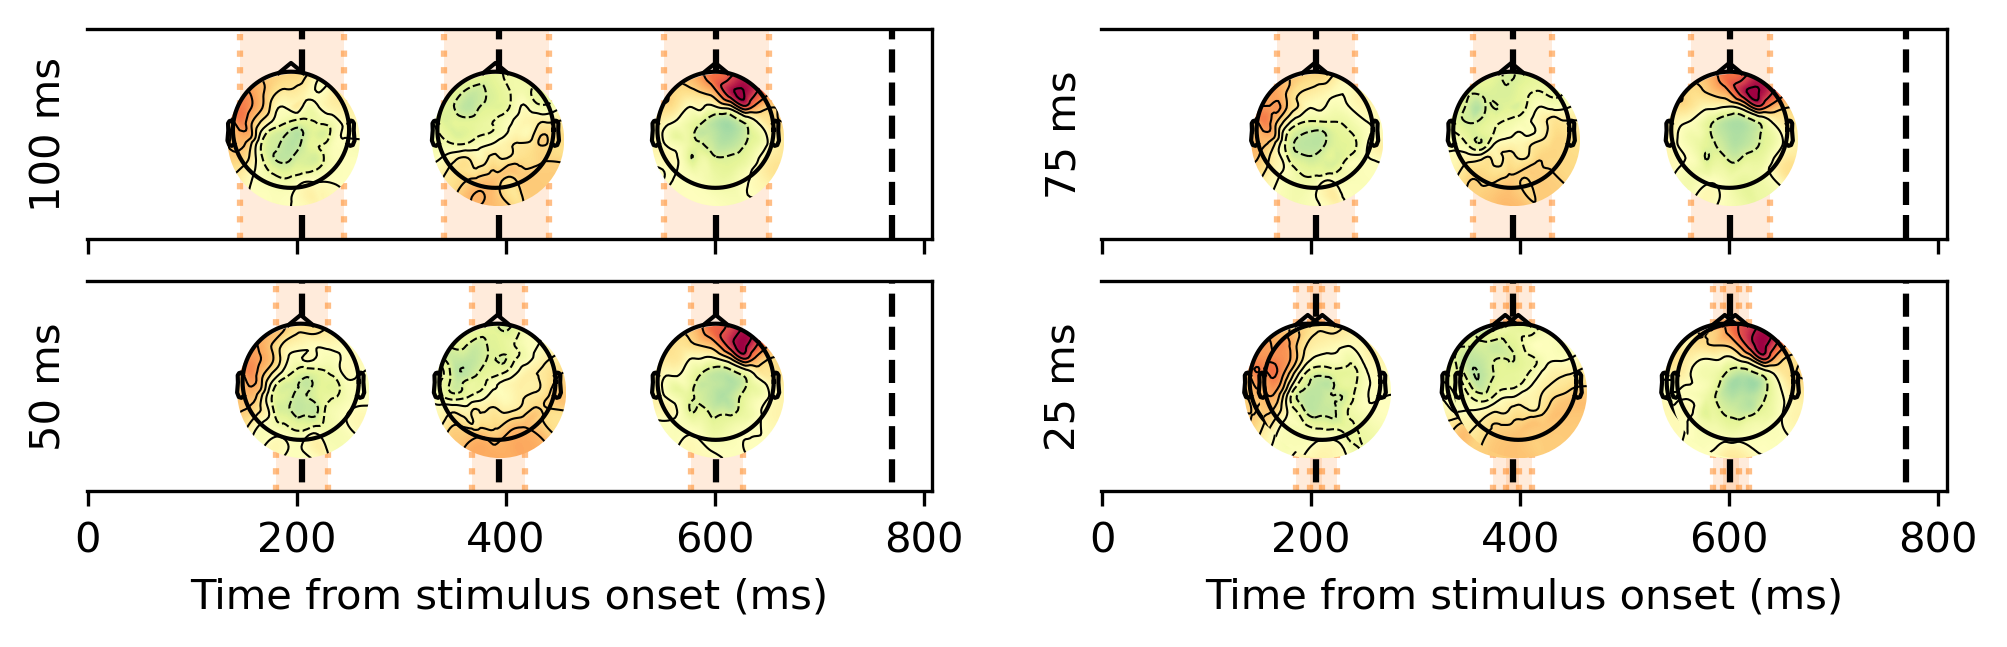

In [9]:
true_dur = 100
true_freq = 1000/true_dur/2# conversion to frequency given half-sine duration above

sources = []
for source in range(len(name_sources)):
    sources.append([name_sources[source], true_freq, amplitude, \
            sp_dist(shape, scale=times[source])])
file = simulations.simulate(sources, n_trials, cpus, 'demo_100-dur', path=path, 
                    overwrite=False, sfreq=sfreq, seed=seed)
#Recover info from simulation
generating_events = np.load(file[1])
resp_trigger = int(np.max(np.unique(generating_events[:,2])))#Resp trigger is the last source in each trial
event_id = {'stimulus':1}#trigger 1 = stimulus
resp_id = {'response':resp_trigger}#Response is defined as the last trigger in a sequence of events
#Keeping only stimulus and response triggers
events = generating_events[(generating_events[:,2] == 1) | (generating_events[:,2] == resp_trigger)]#only retain stimulus and response triggers

number_of_sources = len(np.unique(generating_events[:,2])[1:])#one trigger = one source
epoch_data = hmp.utils.read_mne_data(file[0], event_id=event_id, resp_id=resp_id, 
                sfreq=sfreq, events_provided=events, verbose=False)
    
hmp_data = hmp.utils.transform_data(epoch_data, apply_standard=False, n_comp=n_comp)
fig, ax = plt.subplots(2,2, figsize=(8,2),sharex=True, dpi=300)
ax = ax.flatten()
for i,test_event_width in enumerate(durations):
    print(test_event_width)
    # Estimating an HMP model
    test_init = hmp.models.hmp(hmp_data, sfreq=sfreq, event_width=test_event_width, cpus=cpus, distribution=distribution, shape=shape)#Initialization of the model
    random_source_times, _, _, _ = hmp.simulations.simulated_times_and_parameters(generating_events, init=test_init)

    fit = test_init.fit(verbose=False, pval=.05)
    hmp.visu.plot_topo_timecourse(epoch_data, fit, info, test_init, magnify=2, ax=ax[i], sensors=False, 
        times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0), colorbar=False, cmap='Spectral_r')
    ax[i].set_ylabel('%i ms'%test_event_width)
ax[i].set_xlabel('Time from stimulus onset (ms)')
ax[2].set_xlabel('Time from stimulus onset (ms)')

plt.savefig('../../plots/event_duration-100.png',dpi=300,transparent=True,bbox_inches='tight')
plt.show()